# GAN 인 액션

4-1 임포트하기

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

4-2 모델의 입력 차원

In [3]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

z_dim = 100

4-3 DCGAN 생성자

In [4]:
def build_generator(z_dim):
    
    model = Sequential()
    
    model.add(Dense(256 * 7 * 7, input_dim = z_dim))          #완전 연결 층을 사용해 입력을 7 x 7 x 256 크기 텐서로 바꾼다.
    model.add(Reshape((7, 7, 256)))
    
    model.add(Conv2DTranspose(128, kernel_size=3, strides = 2, padding = 'same')) # 7 x 7 x 256ㅇ서 14 x 14 x 128 크기 텐서로 바꾸는 전치 합성곱 층
    model.add(BatchNormalization())  # 배치 정규화
    model.add(LeakyReLU(alpha=0.01)) # LeakyReLU 활성화 함수
    model.add(Conv2DTranspose(64, kernel_size = 3, strides = 1, padding = 'same')) # 14 x 14 x 128에서 14 x 14 x 64 크기 텐서로 바꾸는 전치 합성곱 층
    model.add(BatchNormalization())  # 배치 정규화
    model.add(LeakyReLU(alpha=0.01)) # LeakyReLU 활성화 함수
    model.add(Conv2DTranspose(1, kernel_size = 3, strides = 2, padding = 'same')) # 14 x 14 x 64에서 28 x 28 x 1 크기 텐서로 바꾸는 전치 합성곱 층
    model.add(Activation('tanh')) # tanh 활성화 함수를 사용하는 출력층
    
    return model

4-4 DCGAN 판별자

In [6]:
def build_discriminator(img_shape):
    
    model = Sequential()
    
    model.add(
        Conv2D(32,
               kernel_size = 3,
               strides = 2,
               input_shape = img_shape,
               padding = 'same'))            # 28 x 28 x 1 텐서에서 14 x 14 x 32 크기 텐서로 바꾸는 합성곱 층
    
    model.add(LeakyReLU(alpha=0.01))         # LeakyReLU 활성화 함수
    
    model.add(
        Conv2D(64,
               kernel_size = 3,
               strides = 2,
               padding = 'same'))            # 14 x 14 x 32 텐서에서 7 x 7 x 64 크기 텐서로 바꾸는 합성곱 층
    
    model.add(LeakyReLU(alpha=0.01))         # LeakyReLU 활성화 함수
    
    model.add(
        Conv2D(128,
               kernel_size = 3,
               strides = 2,
               padding = 'same'))            # 7 x 7 x 64 텐서에서 3 x 3 x 128 크기 텐서로 바꾸는 합성곱 층
    
    model.add(LeakyReLU(alpha=0.01))         # LeakyReLU 활성화 함수
    
    model.add(Flatten())                     # 시그모이드 활성화 함수를 사용하는 출력층
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

4-5 DCGAN 모델 생성과 컴파일

In [7]:
def build_gan(generator, discriminator):
    
    model = Sequential()
    
    model.add(generator)
    model.add(discriminator)
    
    return model

discriminator = build_discriminator(img_shape)
discriminator.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics = ['accuracy'])

generator = build_generator(z_dim)                                 # 생성자 모델 생성

discriminator.trainable = False                                    # 생성자 훈련시에는 판별자의 파라미터를 고정

gan = build_gan(generator, discriminator)                          # 생성자를 훈련하기 위해 판별자를 고정한 GAN 모델을 생성하고 컴파일
gan.compile(loss = 'binary_crossentropy', optimizer = Adam())

4-6 DCGAN 훈련 반복

In [11]:
losses = []
accuracies = []
iteration_checkopints = []

def train(iterations, batch_size, sample_interval):
    
    (X_train, _), (_, _) = mnist.load_data()              # MNIST 데이터셋 로드
    
    X_train = X_train / 127.5 - 1.0                       # [0, 255]흑백 픽셀 값을 [-1, 1]로 스케일 조정
    X_train = np.expand_dims(X_train, axis = 3)
    
    real = np.ones((batch_size, 1))                       # 진짜 이미지 레이블: 모두 1
    
    fake = np.zeros((batch_size, 1))                      # 가짜 이미지 레이블: 모두 0
    
    for iteration in range(iterations):
        
        idx = np.random.randint(0, X_train.shape[0], batch_size)   # 진짜 이미지의 랜덤 배치 얻기
        imgs = X_train[idx]
        
        z = np.random.normal(0, 1, (batch_size, 100))              # 가짜 이미지 배치 만들기
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs, real)     # 판별자 훈련하기
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, (batch_size, 100))              # 가짜 이미지 배치 만들기
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs, real)     # 판별자 훈련하기
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, (batch_size, 100))              # 가짜 이미지 배치 만들기
        gen_imgs = generator.predict(z)
        
        g_loss = gan.train_on_batch(z, real)                       # 생성자 훈련하기
        
        if (iteration + 1) % sample_interval == 0:
            
            losses.append((d_loss, g_loss))                        # 훈련이 끝난 후에 그래프 그리기위해 손실과 정확도를 저장하기
            accuracies.append(100.0 * accuracy)
            iteration_checkopints.append(iteration + 1)
            
            print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" %(iteration + 1, d_loss, 100.0 * accuracy, g_loss))  # 훈련 진행과정 출력
            
            sample_images(generator)                               # 생성된 이미지 샘플 출력

4-7 생성된 이미지 출력

In [9]:
def sample_images(generator, image_grid_rows = 4, image_grid_columns = 4):
    
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))      # 랜덤한 잡음 샘플링
    
    gen_imgs = generator.predict(z)                                                # 랜덤한 잡음에서 이미지 생성
    
    gen_imgs = 0.5 * gen_imgs + 0.5                                                # 이미지 픽셀 값을 [0, 1] 범위로 스케일 조정
    
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize = (4, 4), sharey = True, sharex = True)
    
    cnt = 0
    
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')                  # 이미지 그리드 출력
            axs[i, j].axis('off')
            cnt += 1
            
    plt.show()

4-8 모델 실행

4/4 [==============================] - 1s 371ms/step
10000 [D 손실: 0.263479, 정확도: 88.67%] [G 손실: 3.336304]
1/1 [==============================] - 0s 490ms/step


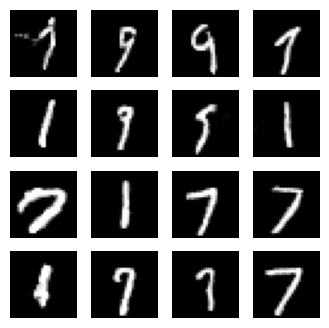

4/4 [==============================] - 4s 1s/step


In [12]:
iterations = 20000           # 하이퍼파라미터 설정
batch_size = 128
sample_interval = 10000

train(iterations, batch_size, sample_interval)  # 지정된 반복 횟수만큼 DCGAN 훈련

DCGAN은 GAN 프레임워크의 유연성을 잘 보여준다. 이론적으로 판별자와 생성자는 미분 가능한 어떤 함수로도 표현할 수 있다.\
심지어 다층 합성곱 신경망처럼 복잡한 것도 가능하다. 하지만 DCGAN은 실전에서 더 복잡한 구현을 만드는 데 어려움이 있다는 것도 보여준다\
배치 정규화와 같은 혁신적인 아이디어가 없다면 DCGAN은 잘 훈련되지 못할 것이다.

* 합성곱 신경망(ConvNet)은 하나 이상의 합성곱 필터를 사용해 입력 텐서 위를 슬라이딩한다. \
입력 위를 슬라이딩하는 각 단계마다 필터는 일련의 파라미터 집합을 사용해 하나의 활성화 값을 만든다.\
필터가 만드는 활성화 값을 모두 모아서 출력을 생성한다.

* 배치 정규화는 신경망에서 공변량변화(훈련하는 동안 층 간의 입력 분포 변화)를 감소시키는 방법이다.\
입력을 다음 층으로 전달하기 전에 각 층의 출력을 정규화한다.

* 심층 합성곱 GAN(DCGAN)은 생성자와 판별자에 합성곱 신경망을 사용하는 생성적 적대 신경망이다. \
튜토리얼에서 규현했던 이 구조는 손글씨 숫자 생성과 같은 이미지 처리 작업에서 뛰어난 성능을 달성한다.